# Projekt

### Spis treści 
<a id="spis"></a>

1. [Generator zbiorow](#generator)
2. [Wybor zbiorow](#ustalenieZbiorow)
3. [Wizualizacja dla algorytmu Jarvisa](#jarvis)

    - [Jarvis dla zbioru typu a](#jarvisa)
    - [Jarvis dla zbioru typu b](#jarvisb)
    - [Jarvis dla zbioru typu c](#jarvisc)
    - [Jarvis dla zbioru typu d](#jarvisd)
    
4. [Wizualizacja dla algorytmu Grahama](#graham)

    - [Graham dla zbioru typu a](#grahama)
    - [Graham dla zbioru typu b](#grahamb)
    - [Graham dla zbioru typu c](#grahamc)
    - [Graham dla zbioru typu d](#grahamd)
    
5. [Wizualizacja dla algorytmu Gorna-dolna](#goradol)

    - [Gorna-dolna dla zbioru typu a](#goradola)
    - [Gorna-dolna dla zbioru typu b](#goradolb)
    - [Gorna-dolna dla zbioru typu c](#goradolc)
    - [Gorna-dolna dla zbioru typu d](#goradold)
    
6. [Wizualizacja dla algorytmu Przyrostowego](#przyrost)

    - [Przyrostowy dla zbioru typu a](#przyrosta)
    - [Przyrostowy dla zbioru typu b](#przyrostb)
    - [Przyrostowy dla zbioru typu c](#przyrostc)
    - [Przyrostowy dla zbioru typu d](#przyrostd)
    
7. [Wizualizacja dla algorytmu Dziel i zwyciezaj](#dziel)
    - [Dziel i zwyciezaj dla zbioru typu a](#dziela)
    - [Dziel i zwyciezaj dla zbioru typu b](#dzielb)
    - [Dziel i zwyciezaj dla zbioru typu c](#dzielc)
    - [Dziel i zwyciezaj dla zbioru typu d](#dzield)
    
8. [Wizualizacja dla algorytmu Chana](#chan)
    - [Chan dla zbioru typu a](#chana)
    - [Chan dla zbioru typu b](#chanb)
    - [Chan dla zbioru typu c](#chanc)
    - [Chan dla zbioru typu d](#chand)
    
9. [Wizualizacja dla algorytmu Quick hull](#quickhull)
    - [Quick hull dla zbioru typu a](#quickhulla)
    - [Quick hull dla zbioru typu b](#quickhullb)
    - [Quick hull dla zbioru typu c](#quickhullc)
    - [Quick hull dla zbioru typu d](#quickhulld)


<a id='section_id'></a>

### Konfiguracja
<a id="konfiguracja"></a>

<a id='section_id'></a>

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

<a id='section_id'></a>

# Utilities


<a id='section_id'></a>

In [22]:
from random import randint
from copy import deepcopy
import math

def divide(points,m): #dzieli zbior punktow na w miarae rowne podzbiory o rozmiarze m lub m-1
    n=len(points)
    for i in range(1,n):#gwarantuje, ze w pierwszym zbiorze Qi pierwszy element jest najnizszy, czyli nalezy do otoczki ostatecznej
        if points[i][1] < points[0][1]:
            buf=points[i]
            points[i] = points[0]
            points[0]=buf
            
    k=math.ceil(n/m)
    Q=[[] for i in range(k)]
    i=0
    while i<n:
        for j in range(k):
            if i==n:
                break
            Q[j].append(points[i])
            i+=1
    if len(Q[0]) > m:
        return None
            
    return Q

def makeSheaf(Points): #laczy punkty w kolejnosci jakiej sa podane
    Sheaf=[]
    for i in range(len(Points)-1):
        Sheaf.append([Points[i],Points[i+1]])
    return Sheaf

def makeFullSheaf(Points): #laczy punkty w kolejnosci jakiej sa podane, dodatkowo domyka cylk
    Sheaf=[]
    for i in range(len(Points)-1):
        Sheaf.append([Points[i],Points[i+1]])
    Sheaf.append([Points[len(Points)-1],Points[0]])
    return Sheaf

def length(v):
     return np.sqrt((v[1][0]-v[0][0])**2+(v[1][1]-v[0][1])**2)

def det(a,b,c):
    return a[0]*b[1]-a[0]*c[1]-b[0]*a[1]+b[0]*c[1]+c[0]*a[1]-c[0]*b[1]

def tangent(p, Q, accur=0):  # Q-zbior punktow w formie otoczki
    # wykorzystujemy binary search na otoczce - jesli dany wierzcholek jest po prawej stronie punktu tworzacej styczna
    # lewostronna z p, 
    ln = len(Q)

    def tangetUtil(p, Q, l, r):
        if r < l:  # zdarza sie tylko, gdy punkt jest wewnatrz otoczki
            return None

        mid = (l + r) // 2
        if det(Q[0], Q[1], p) > 0 and det(Q[ln - 1], Q[0], p) > 0:
            if (det(Q[0], p, Q[mid]) < 0) or (det(p, Q[mid], Q[(mid + 1) % ln]) < 0 and \
                                              det(p, Q[mid], Q[(mid - 1) % ln]) < 0) or \
                    (det(p, Q[mid], Q[(mid + 1) % ln]) < 0 and det(p, Q[mid], Q[(mid - 1) % ln]) >= 0):
                return tangetUtil(p, Q, mid + 1, r)

        else:
            if det(Q[0], p, Q[mid]) >= 0 and \
                    ((det(p, Q[mid], Q[(mid + 1) % ln]) < 0 and det(p, Q[mid], Q[(mid - 1) % ln]) >= 0) or \
                     (det(p, Q[mid], Q[(mid + 1) % ln]) < 0 and det(p, Q[mid], Q[
                         (mid - 1) % ln]) < 0)):  # chyba nie potrzebne sprawdz na koncu
                return tangetUtil(p, Q, mid + 1, r)

        if det(p, Q[mid], Q[(mid + 1) % ln]) >= 0 and det(p, Q[mid], Q[(mid - 1) % ln]) >= 0 \
                or (det(p, Q[mid], Q[(mid + 1) % ln]) == 0 and (Q[mid][0] <= p[0] <= Q[(mid + 1) % ln][0]) and \
                    (Q[mid][1] <= p[1] <= Q[(mid + 1) % ln][1])):

            while (det(p, Q[mid], Q[(mid + 1) % ln]) == 0):
                mid = (mid + 1) % ln  # jesli jest styczna wspolliniowa, to bierzmy pod uwage punkt blizszy
            return mid

        else:
            return tangetUtil(p, Q, l, mid - 1)

    
    return tangetUtil(p, Q, 0, ln - 1)

def randomColor():
    return list(mcolors.CSS4_COLORS)[randint(0,len(list(mcolors.CSS4_COLORS))-1)]


def compr(p,q,current,accur=10**(-6)):#jezeli p jest po prawej  odcinka [current,q] - jest 'wiekszy', to zwracamy 1
        if det(current,p,q)>accur:
            return -1
        elif det(current,p,q)<accur:
            return 1
        else:
            return 0
        

<a id='section_id'></a>

<a id='section_id'></a>

# Genertor zbiorów punktów

<a id="generator"></a>
[spis treści](#spis)

<a id='section_id'></a>

<a id='section_id'></a>

In [41]:
import random 
import math
def makeAset(n,x1=-100,y1=100,x2=-100,y2=100):
    return [(random.randint(x1,y1), random.randint(x2,y2)) for i in range(n)]

def makeBset(n,xs=0,ys=0,r=100):
    b = []
    for _ in range(n):
        t = random.random() * (2*math.pi)
        b.append((r*math.sin(t)-xs, r*math.cos(t)-ys))
    return b
        
def makeCset(n,x1=-100,y1=-100,x2=100,y2=-100,x3=100,y3=100,x4=-100,y4=100): # wierzcholki musza byc podawane 
# kolejno w przeciwnym kierunku do ruchu wskazowek 
# zegara makeCset tworzy wszelakie czworokaty, bioirac pod uwage ze prostokaty moglyby byc przechylone wyznaczanie zbiorow
# punktow dla nich bylo by rownie trudne
    C=[]
    a=np.sqrt((x1-x2)**2+(y1-y2)**2)
    b=np.sqrt((x2-x3)**2+(y2-y3)**2)
    c=np.sqrt((x3-x4)**2+(y3-y4)**2)
    d=np.sqrt((x1-x4)**2+(y1-y4)**2)
    obw=a+b+c+d
    s=random.random()*obw

    for _ in range(n):
        s =random.random() * obw
        if s<=a:
            C.append(((x1+(s/a)*(x2-x1),y1+(y2-y1)*(s/a))))
        elif s<=a+b:
            C.append((x2+(x3-x2)*((s-a)/b),y2+(y3-y2)*((s-a)/b)))
        elif s<=a+b+c:
            C.append((x3+(x4-x3)*((s-a-b)/c),y3+(y4-y3)*((s-b-a)/c)))
        else:
            C.append((x4+(x1-x4)*((s-a-b-c)/d),y4+(y1-y4)*((s-b-a-c)/d)))
    return C

def makeDset(x1=0,y1=0,x2=10,y2=0,x3=10,y3=10,x4=0,y4=10,n1=100,n2=100,n=0):
    if(n!=0):
        n1=n
        n2=n
    D=[]
    D.append((x1,y1))
    D.append((x2,y2))
    D.append((x3,y3))
    D.append((x4,y4))
    a=np.sqrt((x2-x1)**2+(y2-y1)**2)
    d=np.sqrt((x3-x1)**2+(y3-y1)**2)
    
    for _ in range(n1):
        s=random.random()*a
        D.append((x1+(x2-x1)*(s/a),y1+(y2-y1)*(s/a)))
        D.append((x4+(x1-x4)*(s/a),y4+(y1-y4)*(s/a)))
    for _ in range(n2):
        s=random.random()*d
        D.append((x1+(x3-x1)*(s/d),y1+(y3-y1)*(s/d)))
        D.append((x2+(x4-x2)*(s/d),y2+(y4-y2)*(s/d)))
    return D   
%matplotlib notebook

    


<a id='section_id'></a>

## Wybor zbiorow

<a id="ustalenieZbiorow"></a>
[spis treści](#spis)


<a id='section_id'></a>

In [42]:
a=makeAset(n=100)
b=makeBset(n=100)
c=makeCset(n=100)
d=makeDset(n=100)

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

# Sekcja Wizualizacji

<a id="wizualizacja"></a>


<a id='section_id'></a>

## Algorytm Jarvisa

<a id="jarvis"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)


<a id='section_id'></a>

### Kod

<a id='section_id'></a>

In [54]:
def jarvis_vis(points):
    
    plot = Plot(scenes=[Scene(points=[PointsCollection(points, marker='.')])])
    lines = []
    count = 0

    # Tolerancja dla 0
    EPS = 1e-8

    # znajdujemy indeks punktu o najmniejszej rzędnej (jeżeli jest wiele - 
    # to bierzemy ten z nich o najmniejszej odciętej)
    istart = 0
    convex_hull = []
    
    # rozmiar tablicy dzielimy przez 2, ponieważ każdy punkt jest liczony za 2 w np.array
    for i in range(len(points)):
        if points[i][1] < points[istart][1]:
            istart = i
        elif points[i][1] == points[istart][1] and points[i][0] < points[istart][0]:
            istart = i
     
    # zbieramy indeksy punktów na otoczce
    convex_hull.append(istart)

    irand = 0 if istart != 0 else 1
    
    vec = (points[irand][0] - points[istart][0],points[irand][1] - points[istart][1])
    prev = istart
    while True:
#         print('jarvis: petla while')
        imax = irand
        
        plot.add_scene(Scene(points=[PointsCollection(points, marker='.'), 
                                    PointsCollection(points[convex_hull], color='r')],
                            lines=[LinesCollection(lines[:count], color='r')]))
        count += 1
            
            
        for i in range(points.size // 2):
            if i != prev and i != imax:
                orient = orientation(points[prev], points[imax], points[i], EPS)
                # jeżeli punkt jest po prawej stronie rozważanego wektora,
                #to jest nowym kandydatem na punkt otoczki
                if orient == -1:
                    imax = i
                    
                # jeżeli jest zerem (z dokładnością do tolerancji)
                # to sprawdzamy odległośc i bierzemy ten dalszy
                elif orient == 0 and (dist(points[prev], points[imax]) < dist(points[prev], points[i])):
                    imax = i
                    
                plot.add_scene(Scene(points=[PointsCollection(points, marker='.'), 
                                            PointsCollection(points[convex_hull], color='r'),
                                            PointsCollection([points[i]], color='indigo'),
                                            PointsCollection([points[imax]], color='green')],
                                    lines=[LinesCollection(lines[:count], color='r'),
                                            LinesCollection([[points[prev], points[i]]], color='indigo', linestyle='--'),
                                            LinesCollection([[points[prev], points[imax]]], color='green', linestyle='--')]))

                        
        # dlaczego to od razu dodaje całą otoczkę? xDD
        lines.append([points[prev], points[imax]])
                        
                
        # po wykonaniu tej pęli w imax znajduje sie indeks punktu "do którego kąt skierowany jest najmniejszy"
        # ==> należy on do otoczki (chyba, że inny punkt jest wspóliniowy? to co wtedy??)
        # W TYM MIEJSCU NALEŻY DODAĆ KRAWĘDŹ DO WIZUALIZACJI! (zapamiętać ją)
        # jeżeli dojedziemy do punktu początkowego to kończymy
        if imax == istart:
            break;


        convex_hull.append(imax)
        vec = points[imax] - points[prev]
        prev = imax
    
    
    plot.scenes.insert(0, Scene(points=[PointsCollection(points, marker='.'),
                                        PointsCollection(points[convex_hull], color='r')],
                                lines=[LinesCollection(lines[:count], color='r')]))
    plot.add_scene(Scene(points=[PointsCollection(points, marker='.'), 
                                PointsCollection(points[convex_hull], color='r')],
                        lines=[LinesCollection(lines[:count], color='r')]))
    return points[convex_hull], plot

<a id='section_id'></a>

### Jarvis - wizualizacja dla chmury punktów

<a id="jarvisa"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#jarvis)

<a id='section_id'></a>

In [55]:
%matplotlib notebook
cos,plot=jarvis_vis(a)
plot.draw()

TypeError: list indices must be integers or slices, not list

<a id='section_id'></a>

### Jarvis - wizualizacja dla punktów o rozkładzie kołowym

<a id="jarvisb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#jarvis)

<a id='section_id'></a>

<a id='section_id'></a>

### Jarvis - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="jarvisc"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#jarvis)

<a id='section_id'></a>

<a id='section_id'></a>

### Jarvis - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="jarvisd"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#jarvis)

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

## Algorytm Grahama

<a id="graham"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

<a id='section_id'></a>

### Kod  

In [14]:
def graham(points,accur=10**(-6),scen=False):
    lwst=min(points,key=lambda x:(x[1],x[0]))
    points.remove(lwst)
    
###sortowanie wzgledem katow    
    import functools
    def compare(p,q):
        if det(lwst,p,q)>accur:
            return -1
        elif det(lwst,p,q)<(-accur):
            return 1
        else:
            return 0
    points.sort(key=functools.cmp_to_key(compare))
#################################   
    
    if scen:
        from copy import deepcopy
        Points=deepcopy(points)
        scenes=[]
        scenes.append(Scene([PointsCollection(Points)]))
        
    from collections import deque
    stack=deque()
    stack.append(lwst)
    stack.append(points[0])
    vect=[lwst,points[0]]
    i=1
    if scen :
        canceled=False
    while(i<len(points)):
    #begin
        if scen and  not canceled:
            scenes.append(Scene([PointsCollection(Points),
                               PointsCollection(list(stack),color='green')],
                               [LinesCollection(makeSheaf(list(stack)),color='green')]))
        
        if det(vect[0],vect[1],points[i])>accur:
            stack.append(points[i])
            vect[0]=vect[1]
            vect[1]=points[i]
            i+=1
            if scen:
                canceled=False
            
        elif det(vect[0],vect[1],points[i])<(-accur):
            ############################################3
            if scen:
                scenes.append(Scene([PointsCollection(Points),
                                   PointsCollection(list(stack),color='green'),
                                    PointsCollection([points[i]],color='red')],
                                   [LinesCollection(makeSheaf(list(stack)),color='green'),
                                   LinesCollection([[vect[1],points[i]]],color='red')]))
                canceledd=True
                
            vect[1]=vect[0]
            stack.pop() #usuniecie vect[1]
            stack.pop() #usuniecie vect[0](niestety trzeba tak, zeby sie dostac nizej stosu) 
            vect[0]=stack.pop()
            stack.append(vect[0])
            stack.append(vect[1])
            
        else:
            if length([vect[0],points[i]])>length(vect):#postepujemy analogicznie do wyzszego przypadku, chyba ze vect, to dwa pierwsze wierzcholki
                if scen:
                    scenes.append(Scene([PointsCollection(Points),
                                       PointsCollection(list(stack),color='green'),
                                        PointsCollection([points[i]],color='pink'),
                                        PointsCollection([vect[1]],color='pink')],
                                       [LinesCollection(makeSheaf(list(stack)),color='green'),
                                       LinesCollection([[vect[1],points[i]],[vect[0],vect[1]]],color='pink')]))
                    canceled=True
                    
                vect[1]=vect[0]
                stack.pop() #usuniecie vect[1]
                if stack.pop() ==lwst: #usuniecie vect[0] i jednoczesne rozpatrzenie przypadku szczegolnego
                    vect[0]=lwst
                    vect[1]=points[i]
                    stack.append(vect[0])
                    stack.append(vect[1])
                vect[0]=stack.pop()
                stack.append(vect[0])
                stack.append(vect[1])  
            else:
                if scen:
                    scenes.append(Scene([PointsCollection(Points),
                                       PointsCollection(list(stack),color='green'),
                                        PointsCollection([points[i]],color='pink')],
                                       [LinesCollection(makeSheaf(list(stack)),color='green')]))
                    canceled=True
                i+=1
    #end
    points.append(lwst)
    if scen:
        scenes.append(Scene([PointsCollection(Points),
                            PointsCollection(list(stack),color='red')],
                               [LinesCollection(makeFullSheaf(list(stack)),color='red')]))
        return Plot(scenes)
    return list(stack)

<a id='section_id'></a>

### Graham - wizualizacja dla chmury punktów

<a id="grahama"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#graham)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


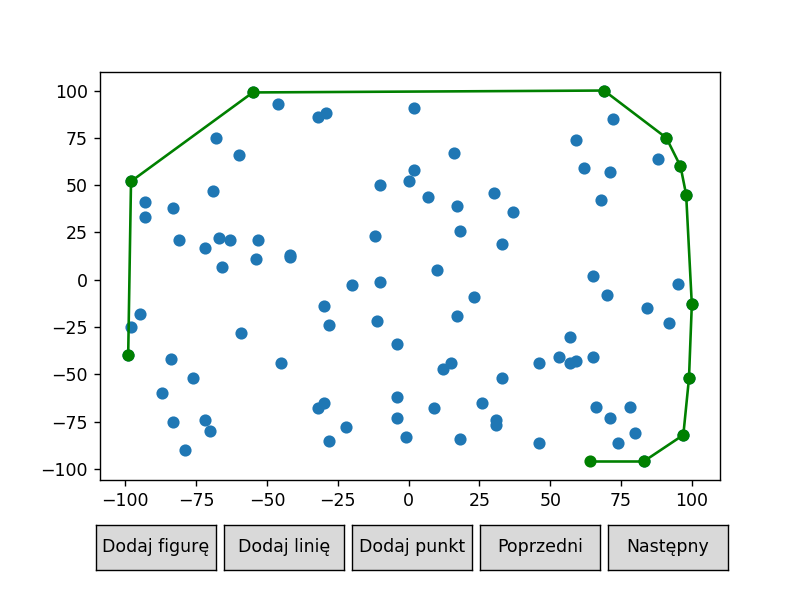

In [15]:
%matplotlib notebook
plot=graham(a,scen=True)
plot.draw()

<a id='section_id'></a>

### Graham - wizualizacja dla punktów o rozkładzie kołowym

<a id="grahamb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#graham)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


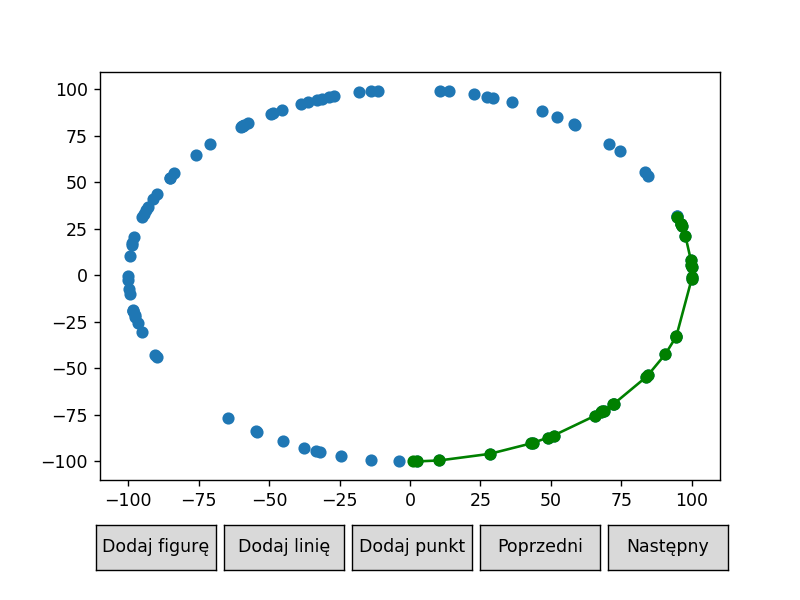

In [16]:
%matplotlib notebook
plot=graham(b,scen=True)
plot.draw()

<a id='section_id'></a>

### Graham - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="grahamac"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#graham)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


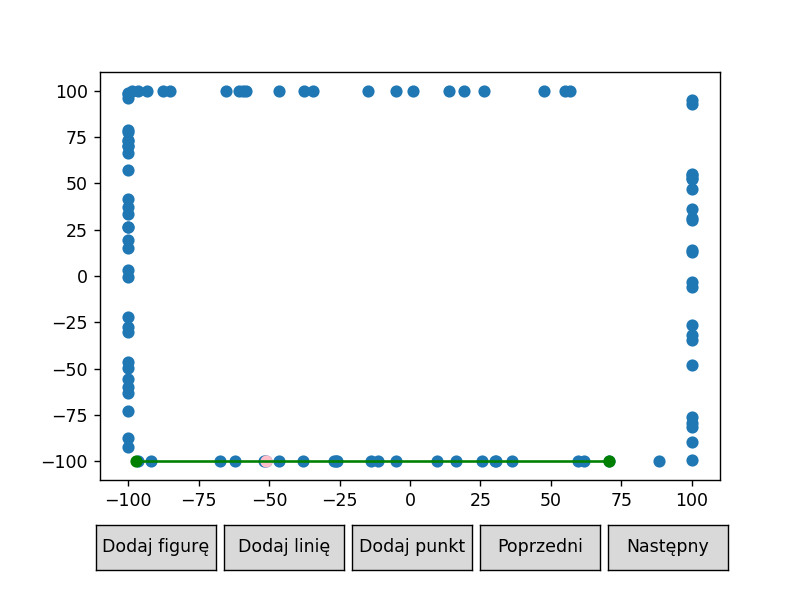

In [43]:
%matplotlib notebook
plot=graham(c,scen=True)
plot.draw()

<a id='section_id'></a>

### Graham - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="grahamd"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#graham)
            

In [ ]:
%matplotlib notebook
plot=graham(d,scen=True)
plot.draw()

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

## Algorytm gorna - dolna

<a id="goradol"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

<a id='section_id'></a>

### Kod

<a id='section_id'></a>

<a id='section_id'></a>

### Gorna-dolna - wizualizacja dla chmury punktów

<a id="goradola"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#goradol)

<a id='section_id'></a>

<a id='section_id'></a>

### Gorna-dolna - wizualizacja dla punktów o rozkładzie kołowym

<a id="goradolb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#goradol)

<a id='section_id'></a>

<a id='section_id'></a>

### Gorna-dolna - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="goradolc"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#goradol)

<a id='section_id'></a>

<a id='section_id'></a>

### Gorna-dolna - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="goradold"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#goradol)

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

## Algorytm przyrostowy

<a id="przyrost"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

<a id='section_id'></a>

### Kod

<a id='section_id'></a>

<a id='section_id'></a>

### Przyrostowy - wizualizacja dla chmury punktów

<a id="przyrosta"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#przyrost)

<a id='section_id'></a>

<a id='section_id'></a>

### Przyrostowy- wizualizacja dla punktów o rozkładzie kołowym

<a id="przyrostb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#przyrost)

<a id='section_id'></a>

<a id='section_id'></a>

### Przyrostowy - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="przyrostc"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#przyrost)

<a id='section_id'></a>

<a id='section_id'></a>

### Przyrostowy - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="przyrostd"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#przyrost)

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

## Algorytm dziel i zwyciezaj

<a id="dziel"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

<a id='section_id'></a>

### Kod

<a id='section_id'></a>

<a id='section_id'></a>

### Dziel i zwyciezaj - wizualizacja dla chmury punktów

<a id="dziela"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#dziel)

<a id='section_id'></a>

<a id='section_id'></a>

### Dziel i zwyciezaj - wizualizacja dla punktów o rozkładzie kołowym

<a id="dzielb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#dziel)

<a id='section_id'></a>

<a id='section_id'></a>

### Dziel i zwyciezaj  - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="dzielc"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#dziel)

<a id='section_id'></a>

<a id='section_id'></a>

### Dziel i zwyciezaj  - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="dzield"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#dziel)

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

## Algorytm chana

<a id="chan"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

<a id='section_id'></a>

### Kod

<a id='section_id'></a>

In [25]:
def nextvert(C,curr,plot=None,ans=None,points=None):#dla danego punktu wspolzednymi z Q[i][j] jesli jest to punkt nalezacy do finalnej otoczki, to
    #zwraca nastepny punkt nalezacy do finalnej otoczki zadanego w takich samych wspolzednych Q[nxt[0]][nxt[1]]
    i,j=curr
    nxt=(i,(j+1)%len(C[i]))
    for k in range(len(C)):
        t=tangent(C[i][j],C[k])
        if t== None : 
            continue
        
        if plot!=None:
            plot.add_scene(Scene(points=[PointsCollection(deepcopy(points)), PointsCollection(deepcopy(ans),color='green'),
                                         PointsCollection(deepcopy(C[k]),color='red'),
                                         PointsCollection([C[k][t]],color='firebrick'),
                                        PointsCollection([C[nxt[0]][nxt[1]]],color='violet')],
                                lines=[LinesCollection(makeSheaf(ans),color='yellow'),
                                      LinesCollection([[ans[len(ans)-1],C[nxt[0]][nxt[1]]]],color='violet'),
                                      LinesCollection([[ans[len(ans)-1],C[k][t]]],color='firebrick'),
                                      LinesCollection(makeFullSheaf(C[k]),color='red')]))
        
        if k!=i and compr(C[nxt[0]][nxt[1]],C[k][t],C[i][j])>0 and (k,t)!=(curr):
            nxt=(k,t)
    
    return nxt

def chanUtil(points,m,plot=None):
    Q=divide(points,m)
    C=[]
    for i in range(len(Q)):
        C.append(graham(Q[i]))
        
    if plot!=None:
        pkt=[PointsCollection(deepcopy(Q[i]),color=randomColor()) for i in range(len(Q))]

        plot.add_scene(Scene(points=pkt))
        
        lns=[LinesCollection(makeFullSheaf(C[i]),color=randomColor()) for i in range(len(C))]
        pkt=[PointsCollection(deepcopy(C[i])) for i in range(len(Q))]
        
        plot.add_scene(Scene(points=pkt,lines=lns))
    
    curr=(0,0)
    ans=[]
    i=0
    while i<m:
        ans.append(C[curr[0]][curr[1]])
        if plot!= None :
            plot.add_scene(Scene(points=[PointsCollection(deepcopy(points)),PointsCollection(deepcopy(ans),color='green')],
                           lines=[LinesCollection(makeSheaf(ans),color='yellow')]))
                               
        nxt=nextvert(C,curr,plot,ans,points)
        if nxt == (0,0):
            return ans
        curr=nxt
        i+=1
        
    
    return None      

def chan(points,visual=False):
    plot=None
    if visual:
        plot=Plot(scenes=[Scene(points=[PointsCollection(deepcopy(points))])])
    n=len(points)
    m=4
    hoax=None
    while hoax==None:
        hoax=chanUtil(points,m,plot)
        m=min(n,m*m)
    
    if visual == True:
        plot.add_scene(Scene(points=[PointsCollection(a),PointsCollection(hoax,color='green')],
                        lines=[LinesCollection(makeFullSheaf(hoax),color='yellow')]))
        return plot
    
    return hoax

<a id='section_id'></a>

### Chan - wizualizacja dla chmury punktów

<a id="chana"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#chan)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


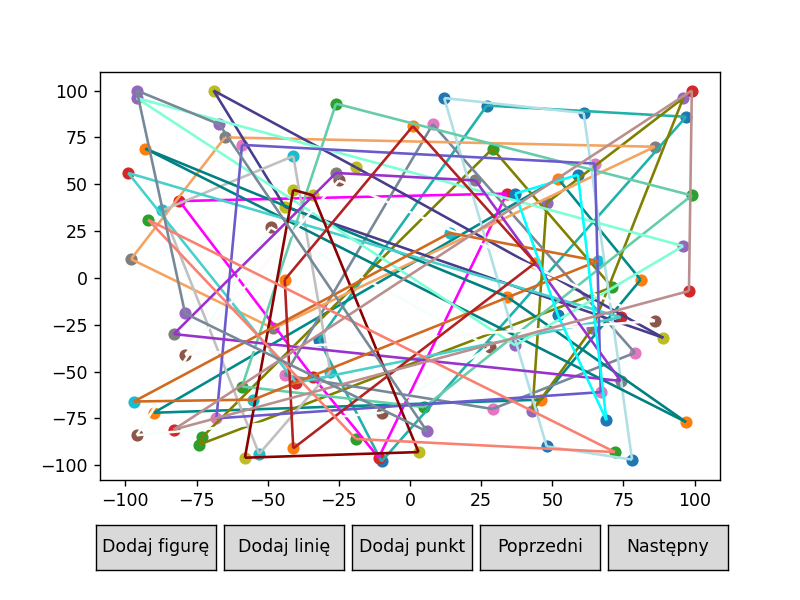

In [26]:
%matplotlib notebook
plot=chan(a,visual=True)
plot.draw()

<a id='section_id'></a>

### Chan  - wizualizacja dla punktów o rozkładzie kołowym

<a id="chanb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#chan)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


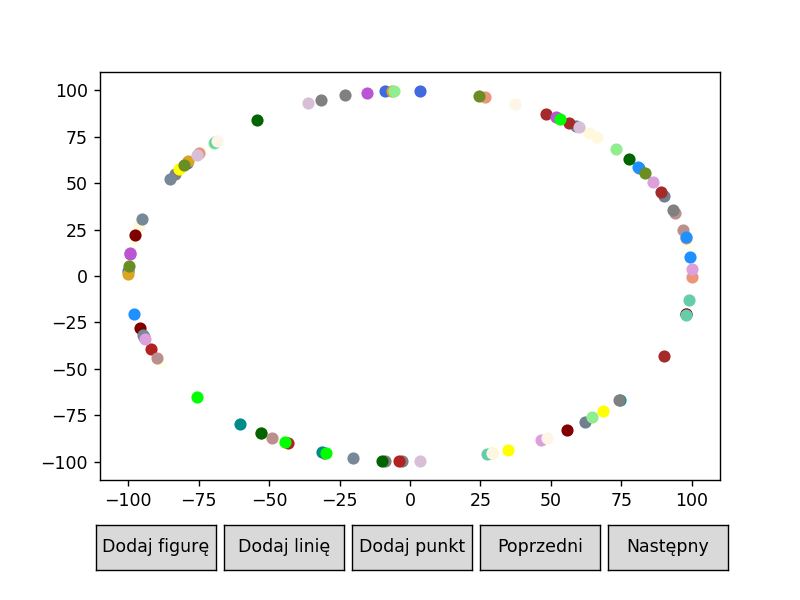

In [27]:
%matplotlib notebook
plot=chan(b,visual=True)
plot.draw()

<a id='section_id'></a>

### Chan   - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="chanc"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#chan)

<a id='section_id'></a>

In [ ]:
%matplotlib notebook
plot=chan(c,visual=True)
plot.draw()

<a id='section_id'></a>

### Chan   - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="chand"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#chan)

<a id='section_id'></a>

In [ ]:
%matplotlib notebook
plot=chan(d,visual=True)
plot.draw()

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

## Algorytm QuickHull

<a id="quickhull"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

<a id='section_id'></a>

### Kod

<a id='section_id'></a>

In [35]:
def furthest(a, b, considering):
    n = len(considering)
    i = 0
    ans = None
    while i < n:
        if det(a, b, considering[i]) < 0:  # rozwazany wierzcholek jest po prawej stronie ab
            if ans == None or det(a, b, considering[i]) < det(a, b,
                                                              ans):  # |det(a,b,c)| = 1/2|ab|*h, gdzie h jest wysokoscia z c na ab
                ans = considering[i]
        i += 1
    return ans


def insideTriangle(a, b, c, i):
    if det(a, b, i) >= 0 and det(b, c, i) >= 0 and det(c, a, i) >= 0:
        return True
    return False


def removeInner(a, b, c, considering):
    new=[]
    for i in considering:
        if not insideTriangle(a, b, c, i):
            new.append(i)
    considering.clear()
    considering+=new

def quickHullUtil(a, b, considering,plot=None,hull=None):     
    if len(considering) == 0:
        return []
    
    if plot!=None :
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(considering)),
                                     PointsCollection(deepcopy(hull),color='green')],
                           lines=[LinesCollection([[a,b]],color='yellow')]))
        
    c = furthest(a, b, considering)
    if c == None:
        return []
    considering.remove(c)
    
    if plot!=None :
        hull.append(c)
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(considering)),
                                     PointsCollection(deepcopy(hull),color='green'),
                                    PointsCollection([c],color='red')],
                           lines=[LinesCollection([[a,b]],color='yellow')]))
    
    if plot!=None :
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(considering)),
                                     PointsCollection(deepcopy(hull),color='green')],
                           lines = [LinesCollection([[a,c],[b,c]],color='yellow')]))

    removeInner(a, c, b, considering)
    
    if plot!=None :
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(considering)),
                                     PointsCollection(deepcopy(hull),color='green')],
                           lines = [LinesCollection([[a,b],[a,c],[b,c]],color='yellow')]))
    
        z=quickHullUtil(a, c, considering,plot,hull)
        
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(considering)),
                                     PointsCollection(deepcopy(hull),color='green')],
                           lines = [LinesCollection([[b,c]],color='yellow')]))
        
        return z +[c]+ quickHullUtil(c, b, considering,plot,hull)
    
    return quickHullUtil(a, c, considering) +[c]+ quickHullUtil(c, b, considering)


def quickHull(points,visual=False):
    a = min(points, key=lambda x: x[0])
    b = max(points, key=lambda x: x[0])

    considering = deepcopy(points)
    
    if visual==True:
        plot=Plot(scenes=[Scene(points=[PointsCollection(deepcopy(considering))])])
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(considering)),
                                     PointsCollection([a,b],color='red')]))

    considering.remove(a)
    considering.remove(b)
    
    
    if visual:
        hull=[a,b]
        hoax =[a]+quickHullUtil(a, b, considering,plot,hull) +[b] + quickHullUtil(b, a, considering,plot,hull)
        plot.add_scene(Scene(points=[PointsCollection(deepcopy(points)),PointsCollection(deepcopy(hoax),color='green')],
                           lines=[LinesCollection(makeFullSheaf(hoax),color='yellow')]))
        return plot
    
    return [a]+quickHullUtil(a, b, considering)+[b]+  quickHullUtil(b, a, considering)

<a id='section_id'></a>

### QuickHull - wizualizacja dla chmury punktów

<a id="quickhulla"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#quickhull)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


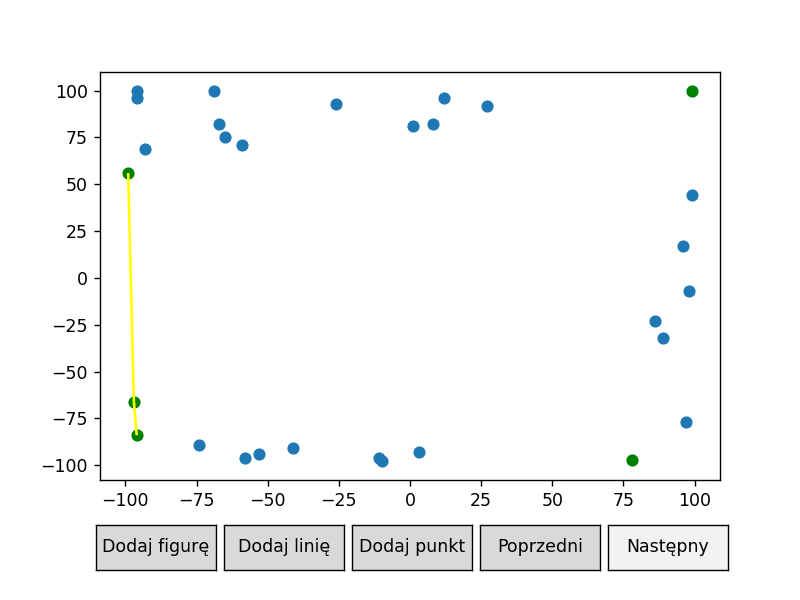

In [36]:
%matplotlib notebook
plot=quickHull(a,visual=True)
plot.draw()

<a id='section_id'></a>

### QuickHull - wizualizacja dla punktów o rozkładzie kołowym

<a id="quickhullb"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#quickhull)

<a id='section_id'></a>

<IPython.core.display.Javascript object>


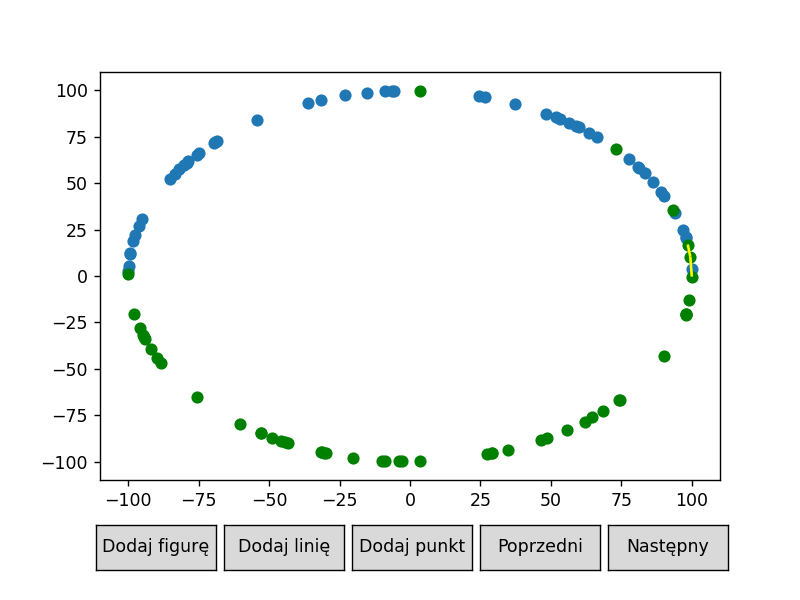

In [37]:
%matplotlib notebook
plot=quickHull(b,visual=True)
plot.draw()

<a id='section_id'></a>

### QuickHull  - wizualizacja dla punktów o rozkładzie prostokątnym

<a id="quickhullc"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#quickhull)

<a id='section_id'></a>

In [ ]:
%matplotlib notebook
plot=quickHull(c,visual=True).
plot.draw()

<a id='section_id'></a>

### QuickHull  - wizualizacja dla punktów o rozkładzie na dwóh bokach, wierzchołkach i przekątnych prostokąta

<a id="quickhulld"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)

[Poczatek sekcji](#quickhull)

<a id='section_id'></a>

In [ ]:
%matplotlib notebook
plot=quickHull(d,visual=True).
plot.draw()

<a id='section_id'></a>

<a id='section_id'></a>

<a id='section_id'></a>

# Sekcja pomiarów czasu

<a id="pomiary"></a>


### Funkcja do pomiaru czasów

<a id='section_id'></a>

In [45]:
import time

def timemesure(setFunction,hoaxFunctions,n1=1000,n2=20000,gaps=100):#zwraca wyniki pomiarów dla danych funkcji
    #w takiej kolejności, w jakeij sa podane w hoax Functions
    
    time_results=[]
    for j in range(n1,n2,gaps):
        time_result=[]
        a=setFunction(n=i)
        for i in range(len(hoaxFunction)):
            start=time.time()
            hoaxFunction(a)
            stop=time.time()
            time_result.append((i,stop-start))
        time_results.append(time_result)
        
    return time_results

<a id='section_id'></a>

<a id='section_id'></a>

## Zredefiniowane kody funkcji funkcji wyznaczających otoczkę bez wizualizacji - wizualizacja mogła by wpływać na korzyść niektórych i niekorzyść innych. Przed uruchomieniem pomiarów czasu uruchomić komórki z nowymi definicjami.

<a id="jarvis"></a>
[spis treści](#spis)

[Wybor zbiorow do wizualizcji](#ustalenieZbiorow)


<a id='section_id'></a>

### Jarvis

<a id='section_id'></a>

<a id='section_id'></a>

### Graham

<a id='section_id'></a>

<a id='section_id'></a>

### Dolna górna

<a id='section_id'></a>

### Przyrostowy

<a id='section_id'></a>

<a id='section_id'></a>

### Dziel i zwyciężaj

<a id='section_id'></a>

<a id='section_id'></a>

### Chan

<a id='section_id'></a>

<a id='section_id'></a>

### Quick Hull

<a id='section_id'></a>

<a id='section_id'></a>

## Pomiary

<a id='section_id'></a>

<a id='section_id'></a>

### Chmura punktów

<a id='section_id'></a>

<a id='section_id'></a>

### Rozkład kołowy

<a id='section_id'></a>

<a id='section_id'></a>

### Losowy rozkład na prostokącie

<a id='section_id'></a>

<a id='section_id'></a>

### Wierzchołki kwadratu, jego przekątne i dwa boki o wspólnym wierzchołku

<a id='section_id'></a>

<a id='section_id'></a>